# Pyiron workflows: A ground-up walkthrough of syntax and features

Contents:
- From function to node
- Making reusable node classes
- Connecting nodes to form a graph
- Syntactic sugar
- Workflows: keeping your computational graphs organized
- Node packages: making nodes re-usable
- Macro nodes: complex computations by composing sub-graphs
- Dragons and the future: remote execution, cyclic flows, and more

To jump straight to how to use `pyiron_workflow`, go look at the quickstart guide -- this jumps straight to using `Workflow` as a single-point-of-access, creating nodes with decorators, and leveraging node packages to form complex graphs.

Here we start from the ground up and do "silly" things like importing _just_ the `Function` class directly from the `pyiron_workflow` package. This isn't meant to show actual practical, recommended use-styles, but rather is indended as a pedagogical deep-dive that builds knowledge from the ground up. While the quickstart is aimed at users who just want to get running, this is intended for people who want to develop nodes for others to use, or for people who are stuck or seeing unexpected behaviour and want a better understanding of what `pyiron_workflow` is doing under the hood.

The next recommendation is to simply read the class and method docstrings directly!

## Instantiating a node

Simple nodes can be defined on-the-fly by passing any callable to a special `Node` class, `Function(Node)`, which transforms the function into a class. Instances of this node have input and output, can be connected to other nodes in a workflow, and can run the function it stores.

Input and output channels are _automatically_ extracted from the signature and return value(s) of the function. (Note: "Nodized" functions must have _at most_ one `return` expression!)

In [1]:
from pyiron_workflow.function import function_node

In [2]:
def plus_minus_one(x):
    return x+1, x-1

pm_node = function_node(plus_minus_one)

This has automatically created a node with input and output data channels whose labels are gathered by inspecting the function:

In [3]:
print(pm_node.inputs.labels, pm_node.outputs.labels)

['x'] ['x+1', 'x-1']


The output is still empty (`NOT_DATA`) because we haven't `run()` the node:

In [4]:
print(pm_node.outputs.to_value_dict())

{'x+1': NOT_DATA, 'x-1': NOT_DATA}


If we try that now though, we'll just get a type error because the input is not set! 

In [5]:
try:
    pm_node.run()
except Exception as e:
    print(f"RAISED {e.__class__.__name__}")
    message = e.args[0]
    print(message)

RAISED ReadinessError
plus_minus_one received a run command but is not ready. The node should be neither running nor failed, and all input values should conform to type hints.
plus_minus_one readiness: False
STATE:
running: False
failed: False
INPUTS:
x ready: False


If we update the input, we'll give the node enough data to work with:

In [6]:
pm_node.inputs.x = 5
pm_node.run()
print(pm_node.outputs.to_value_dict())

{'x+1': 6, 'x-1': 4}


Alternatively, the `run()` command just return the function's return value:

In [7]:
out = pm_node.run()
out

(6, 4)

We can give our function defaults so that it's ready to go from the beginning. Let's also take the opportunity to give our output channel a better name so we can get it by dot-access.

In [8]:
def adder(x: int = 0, y: int = 1) -> int:
    sum_ = x + y
    return sum_

adder_node = function_node(adder)
adder_node.run()
adder_node.outputs.sum_.value  # We use `value` to see the data the channel holds

1

This node also exploits type hinting! Like the variable names, these hints get scraped automatically and added to the channels:

In [9]:
adder_node.inputs.x.type_hint, adder_node.inputs.y.type_hint, adder_node.outputs.sum_.type_hint

(int, int, int)

New values are checked against the node type hint, so trying to assign an incommensurate value will raise an error:

In [10]:
try:
    adder_node.inputs.x = "not an integer"
except TypeError as e:
    print(f"RAISED {e.__class__.__name__}")
    message = e.args[0]
    print(message)

RAISED TypeError
The channel x cannot take the value `not an integer` because it is not compliant with the type hint <class 'int'>


We can bypass this by deactivating the `strict_hinting`, or by assigning a new value directly to the private `_value` attribute. The `run()` will also perform a check that input values conform to type hints before computing anything. Failing at this stage won't actually cause the node to have a `failed` status, so you can just re-run it once the input is fixed.

In [11]:
adder_node.deactivate_strict_hints()
adder_node.inputs.x = "not an integer"
adder_node.activate_strict_hints()
try:
    adder_node.run()
except Exception as e:
    print(f"RAISED {e.__class__.__name__}")
    message = e.args[0]
    print(message)

RAISED ReadinessError
adder received a run command but is not ready. The node should be neither running nor failed, and all input values should conform to type hints.
adder readiness: False
STATE:
running: False
failed: False
INPUTS:
x ready: False
y ready: True


In [12]:
adder_node.inputs.x = 2
adder_node.run()

3

We can also set new input as any valid combination of kwargs and/or args at both instantiation or on call:

In [13]:
adder_node = function_node(adder, 10, y=20)
adder_node.run()

30

Finally, we can update input and then `run` together by calling an already-instantiated node. Just like at node instantiation, the input for `Function` nodes can be set by positional and/or keyword argument. Here we'll use two positional args:

In [14]:
adder_node(15, 16)

31

Note for advanced users: when the node has an executor set, running returns a futures object for the calculation, whose `.result()` will eventually be the function output. This result object can also be accessed on the node's `.result` attribute as long as it's running.

## Reusable node classes

Under the hood, `function_node` is actually dynamically making a new sub-class of `Function` and returning us an instance of that class. If we look at the type, we'll see it's based off the wrapped function (as is the class's `__module__`), and `Function` and the other parent classes appear in the method resolution order:

In [15]:
type(adder_node), adder_node.__module__

(__main__.adder, '__main__')

In [16]:
adder_node.__class__.mro()

[__main__.adder,
 pyiron_workflow.function.Function,
 pyiron_workflow.io_preview.DecoratedNode,
 pyiron_workflow.io_preview.StaticNode,
 pyiron_workflow.node.Node,
 pyiron_workflow.has_to_dict.HasToDict,
 pyiron_workflow.semantics.Semantic,
 pyiron_workflow.run.Runnable,
 pyiron_workflow.injection.HasIOWithInjection,
 pyiron_workflow.io.HasIO,
 pyiron_workflow.has_interface_mixins.UsesState,
 pyiron_workflow.single_output.ExploitsSingleOutput,
 pyiron_workflow.working.HasWorkingDirectory,
 pyiron_workflow.storage.HasH5ioStorage,
 pyiron_workflow.storage.HasTinybaseStorage,
 pyiron_workflow.storage.HasStorage,
 pyiron_workflow.has_interface_mixins.HasLabel,
 pyiron_workflow.has_interface_mixins.HasParent,
 pyiron_workflow.has_interface_mixins.HasRun,
 pyiron_workflow.has_interface_mixins.HasChannel,
 pyiron_workflow.io_preview.ScrapesIO,
 pyiron_workflow.io_preview.HasIOPreview,
 abc.ABC,
 object]

However, there's lots of times where we're going to want a bunch of instances of the same type of node, and we'd really like access to this class directly so we can make new instances more succinctly.

The can be done the traditionaly way directly by inheriting from `Function` and specifying its required `node_function` static method, and (optionally) overriding its `_output_labels` so they are defined by you instead of scraped from the `node_function`

In [17]:
from pyiron_workflow.function import Function

In [18]:
class MySubtractionChild(Function):
    _output_labels = ["diff"]
    
    @staticmethod
    def node_function(x: int | float = 2, y: int | float = 1) -> int | float:
        return x - y

sn = MySubtractionChild()
print("class name =", sn.__class__.__name__)
print("label =", sn.label)

sn()  # Runs without updating input data, but we have defaults so that's fine
print("output with default input = ", sn.outputs.to_value_dict())

class name = MySubtractionChild
label = node_function
output with default input =  {'diff': 1}


Even easier is to use the `as_function_node` decorator to do this for you! 

The decorator lets us easily choose the names of our output channels by passing the `output_labels` argument to the decorator -- as a string to create a single channel for the returned values, or as a list of strings equal to the number of returned values in a returned tuple. The decorator also does nice quality-of-life things like use the decorated function name as the default label for new instances.

In [19]:
from pyiron_workflow.function import as_function_node

In [20]:
@as_function_node("diff")
def Subtract(x: int | float = 2, y: int | float = 1) -> int | float:
    return x - y

sn = Subtract()
print("class name =", sn.__class__.__name__)
print("label =", sn.label)

sn()  # Runs without updating input data, but we have defaults so that's fine
print("output with default input = ", sn.outputs.to_value_dict())

class name = Subtract
label = Subtract
output with default input =  {'diff': 1}


Note that we break with python convention and use PascalCase to name our "function" here -- that's because by the time the decorator is done with it, it is actually a class! Information about the expected IO is available right at the class level:

In [21]:
Subtract.preview_io()

{'inputs': {'x': (int | float, 2), 'y': (int | float, 1)},
 'outputs': {'diff': int | float}}

So is the node functionality, so we can still leverage our node as a normal function if we want:

In [22]:
@as_function_node("square_diff")
def SubtractAndSqaure(x: int | float = 1, y: int | float = 2) -> int | float:
    return Subtract.node_function(x, y)**2
    
ssq = SubtractAndSqaure()
ssq()
print("default output =", ssq.outputs.square_diff.value)

default output = 1


# Connecting nodes and controlling flow

Multiple nodes can be used together to build a computational graph, with each node performing a particular operation in the overall workflow.

The input and output of nodes can be chained together by connecting their data channels to form a data graph.

The flow of execution can be manually configured by using other "signal" channels to form an execution graph. However, for data graphs that are a directed acyclic graph (DAG), the execution flow can be automatically determined from the topology of the data connections!

The `run` command we saw above has several boolean flags for controlling the style of execution. The two main run modes are with a "pull" paradigm, where everything upstream on the graph of data connections is run first then the node invoking `pull` gets run; and with a "push" paradigm (the default for `run`), where the node invoking `run` gets run and then runs everything downstream on the execution graph. Calling an instantiated node runs a particularly aggressive version of `pull` that recursively pulls everything upstream, even breaking out of the context of this particular sub-graph to pull in parent graphs.

We'll talk more about grouping nodes together inside a `Workflow` object, but without a parent workflow, only the `pull` method will automate execution signals; trying to push data downstream using `run` requires specifying the execution flow manually.

Let's start by looking at `pull` in the example below to see how this works for a super-simple toy graph:

In [23]:
@as_function_node()
def Linear(x):
    return x

@as_function_node("double")
def TimesTwo(x):
    return 2 * x

l = Linear()
t2 = TimesTwo()

l.inputs.x = 1
t2.inputs.x = l.outputs.x
t2.signals.input.run = l.signals.output.ran

t2.pull()

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


2

And, as mentioned, `__call__` is just (roughly) an alias for `pull`:

In [24]:
l.inputs.x = 2
t2()

4

Next, lets see how to do this with a "push" paradigm.

Just like the data connections, we can connect the `.signals.inputs.run` and `.signals.output.ran` channels of two nodes, but we can also use the `>>` operator as a syntactic sugar shortcut.

Note how data connections can be made with keyword arguments just like other input data definitions.

With both of these together, we can write:

In [25]:
l = Linear(x=10)
t2 = TimesTwo(x=l.outputs.x)
l >> t2  # Note: We can make arbitrarily long linear chains: l >> t2 >> something_else >> another_node
l.run()
print(t2.inputs.x, t2.outputs.double)

10 20


This is fine for linear chains, but when we introduce parallelization we want a different execution flow; for that we introduce `.signals.inputs.accumulate_and_run`. In contrast to `.signals.inputs.run`, which triggers are run when it receives _any_ signals, `.signals.inputs.accumulate_and_run` only fires its callback after _all_ of its connected `OutputSignal`s have pinged it at least once.

This let's us set up nodes which only start running after _all_ of their up-data-stream nodes have fired their `ran` signal. This is the default behaviour when `Composite` `Workflow` or `Macro` nodes automate their execution flow for DAG data graphs. We'll look at it again near the end of the notebook when we talk about remote execution.

# Output manipulation

Most (but not all) python operations can be performed _directly on output channels_. This works by injecting new nodes after the output channels to perform the requested operation.

Let's look at how we can repeat some of the above examples much more succinctly using this feature:

In [26]:
# Subtract and square

x = Linear(x=4)
y = Linear(x=1)
((x.outputs.x - y.outputs.x)**2).pull()  # It's just a node so we can pull it

9

In case a node has _exactly_ one output channel, operations will fall back on attempting to operate on this one, unambiguous output channel -- i.e. we can operate on (and form connections to the output of) the node directly:

In [27]:
# Times two
l = Linear(x=10, run_after_init=True)
(2*l).value  # These nodes will try to run right away if everything upstream is ready

20

This also works with more sophisticated features like attribute and item access, including slicing:

In [28]:
a_list = Linear(x=[1,2,3,4], run_after_init=True)
a_list.outputs.x[:2].value  # Explicitly on the output channel

[1, 2]

In [29]:
a_list[:2].value  # Or directly on the single-output node

[1, 2]

In [30]:
a_dict = Linear(x={"a": 1, "b": 2}, run_after_init=True)
a_dict["a"].value

1

In [31]:
class Foo:
    bar = 42
    
an_object = Linear(x=Foo(), run_after_init=True)
an_object.bar.value

42

Some features don't work this way, e.g. overriding the `==` operator has other deterious effects so we don't do that. Most of these operators are available as a method on output channels, based on their dunder name. E.g.

In [32]:
a = Linear(x=42)
b = Linear(x=42)
c = Linear(x=0)

a_eq_b = a.outputs.x.eq(b.outputs.x)  # On output channels explicitly
a_eq_c = a.eq(c)  # Or the single-output nodes directly

(a_eq_b | a_eq_c).pull(), (a_eq_b & a_eq_c).pull()

(True, False)

Nodes can take input from multiple sources, and -- although it's usually _useful_ to give each node its own variable -- we can even instantiate nodes inside the signature for initializing another node and call that node all at once! You won't have easy access to them afterwards, but this still just builds three nodes in memory, sets their data connections, and invokes a `pull` on the outermost (downstream-most) node, which automatically creates the execution flow and runs it:

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


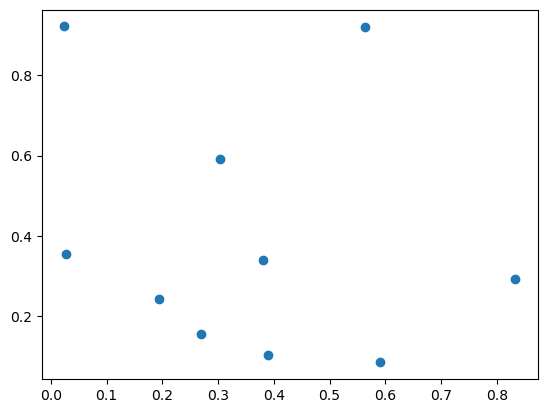

In [33]:
import matplotlib.pyplot as plt
import numpy as np

@as_function_node()
def Noise(length: int = 1):
    array =  np.random.rand(length)
    return array

@as_function_node()
def Plot(x, y):
    fig = plt.scatter(x, y)
    return fig

plot_output = Plot(
    x=Noise(length=10),
    y=Noise(length=10),
)()

## Edge cases

If output labels aren't provided, we try to scrape them from the source code for the function -- but this has limitations, like that the source code needs to be available for inspection and that there's a single return value. 

If explicit output labels _are_ provided, we _still_ try to scrape them from the function source code just to make sure that everything lines up nicely. However, there are a couple of edge cases where you may want to tell the workflow code that you really know what you're serious about your labels and just use them without any validation.

(Failing to find the source code to compare with only triggers a warning, so in-memory functions are still OK as long as you provide output labels.)

Turning off this validation comes with some responsibility that your labels make sense and will work. Let's look at a couple examples:

(1) You might want to return a single tuple, and break it appart into channels

In [34]:
@as_function_node("x0", "x1", validate_output_labels=False)
def ReturnsTuple(x: int) -> tuple[int, float]:
    x = (x, x + 3.14)
    return x

from_tuple = ReturnsTuple(x=7, run_after_init=True)
from_tuple.outputs.to_value_dict()

{'x0': 7, 'x1': 10.14}

(2) To handle multiple return branches -- just be careful that the branches return the same number and type of values, or you may wind up with strange results.

In [35]:

@as_function_node("bool", validate_output_labels=False)
def MultipleBranches(x):
    if x < 10:
        return True
    else:
        return False

switch = MultipleBranches()
print(switch(3), switch(13))

True False


# Workflows

The case where we have groups of connected nodes working together is our normal, intended use case.
We offer a formal way to group these objects together as a `Workflow` object.
`Workflow` also offers us a single point of entry to the codebase -- i.e. most of the time you shouldn't need the node imports used above, because the decorators are available right on the workflow class.

We will also see here that we can rename our node output channels using the `outputs_map: dict[str, str]` kwarg, in case they don't have a convenient name to start with.
This way we can always have convenient dot-based access (and tab completion) instead of having to access things by string-based keys.

Finally, when a workflow is run, unless its `automate_execution` flag has been set to `False` or the data connections form a cyclic graph, it will _automatically_ build the necessary run signals! That means for all directed acyclic graph (DAG) workflows, all we typically need to worry about is the data connections.

Here is an example showing how `Workflow` can be used as a single-point-of-import for defining new nodes:

In [36]:
from pyiron_workflow import Workflow

@Workflow.wrap.as_function_node("is_greater")
def GreaterThanHalf(x: int | float | bool = 0) -> bool:
    """The functionality doesn't matter here, it's just an example"""
    return x > 0.5

## Adding nodes to a workflow

Each node can belong to exactly one workflow...but how to we create a workflow and add nodes to it

All five of the approaches below are equivalent ways to add a node to a workflow. Note that when `create` is called from the workflow _class_ it just gives you access to the class being created; when it is called from a workflow _instance_, it wraps this class so that the created node has its parent value automatically set to the workflow instance that's creating it.

In [37]:
n1 = GreaterThanHalf(label="n1")

wf = Workflow("my_wf", n1)  # As args at init
wf.add_child(GreaterThanHalf(label="n2"))  # Instantiating then passing to node adder
wf.n3 = GreaterThanHalf(label="will_get_overwritten_with_n3")  # Set attribute to instance
GreaterThanHalf(label="n4", parent=wf)  # By passing the workflow to the node

for i, (label, node) in enumerate(wf.children.items()):
    x = i / len(wf)
    node(x=x)
    print(f"{label} == {node.label}) {x} > 0.5 {node.value}")

n1 == n1) 0.0 > 0.5 False
n2 == n2) 0.25 > 0.5 False
n3 == n3) 0.5 > 0.5 False
n4 == n4) 0.75 > 0.5 True


Nodes can also be removed or replaced with the corresponding `remove_child` or `replace_child` methods.

Workflows have inputs and outputs just like function nodes, but these are dynamically created to map to all _unconnected_ input and output for their underlying graph. They automatically get named by connecting the node label and channel label with a double underscore, but this can be overriden by providing an `inputs_map` and/or an `outputs_map` -- these maps can also let you expose data channels that would otherwise be hidden because they have a connection!

In [38]:
wf = Workflow("simple")

@Workflow.wrap.as_function_node()
def AddOne(x):
    y = x + 1
    return y

@Workflow.wrap.as_function_node("sum")
def Add(x, y):
    return x + y

wf.a = AddOne(0)
wf.b = AddOne(0)
wf.sum = Add(wf.a, wf.b)  
wf.inputs_map = {"a__x": "a", "b__x": "b"}
wf.outputs_map = {"a__y": "a + 1", "sum__sum": "a + b + 2"}
# Remember, with single value nodes we can pass the whole node instead of an output channel!

print("inputs:", wf.inputs.labels)
print("outputs:", wf.outputs.labels)

inputs: ['a', 'b']
outputs: ['a + 1', 'a + b + 2']


When `run()` is called on a workflow, it will call `run()` on each node in its `starting_nodes` list and rely on these to propagate the execution with their run signals. If your data flow is DAG-like, all of this gets handled automatically so you just need to call `run()` on the workflow.

If you do have cyclic data flows, or just want more control, you are still free to set the `starting_nodes` and run signals yourself, just don't forget to set `automate_execution=False` on the workflow.

Unlike function nodes, workflow input has no intrinsic order. We can still update it by calling the workflow, but we _need_ to use keyword and not positional arguments. Runs of the workflow then return a dot-accessible dictionary based on the output channels:

In [39]:
out = wf(a=2, b=3)
out

{'a + 1': 3, 'a + b + 2': 7}

Note: Workflows are the "parent-most" node, so even though `__call__` is still invoking a `pull`, the "run all upstream data dependencies" part of "run all upstream data dependencies then run yourself" gets skipped trivially -- workflows can't have siblings or parents so there are no dependencies to run! Thus `__call__` is effectively just a `run`.

We can see now why we've been trying to give succinct string labels to our `Function` node outputs instead of just arbitrary expressions! The expressions are typically not dot-accessible, but can still be grabbed with a key:

In [40]:
out["a + b + 2"]

7

We can also visualize our graph!

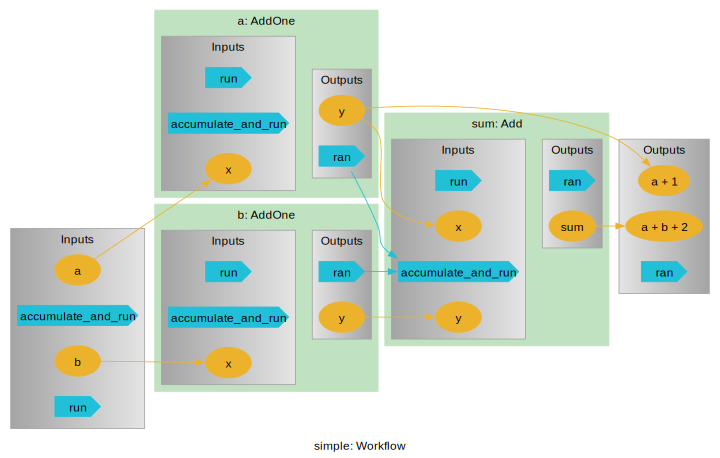

In [41]:
wf.draw(size=(10,10))

# Example with pre-built nodes

Currently we have a handfull of pre-build nodes available for import from the `nodes` package. Let's use these to quickly put together a workflow for looking at some MD data.

To access prebuilt nodes we can `.create` them. This works both from the workflow class _and_ from a workflow instance.

There are a few of nodes that are always available under the `Workflow.create.standard` namespace, otherwise we need to register new node packages. This is done with the `register` method, which takes the domain (namespace/key/attribute/whatever you want to call it) under which you want to register the new nodes, and a string import path to a module that has a list of nodes under the name `nodes`, i.e. the module has the property `nodes: list[pyiron_workflow.node.Node]`. (You can also register a package with arbitrary nesting, where each non-package sub-module (i.e. a leaf .py file) with a `nodes` attribute will attempt to read those nodes as a package. Cf. the atomistics demo notebook for an example of this.) (This API is subject to change, as we work to improve usability and bring node packages more and more in line with "FAIR" principles.)

You can make your own `.py` files with nodes for reuse this way, but `pyiron_workflow` also comes with a couple of packages. In this example we'll use atomistics and plotting:

The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

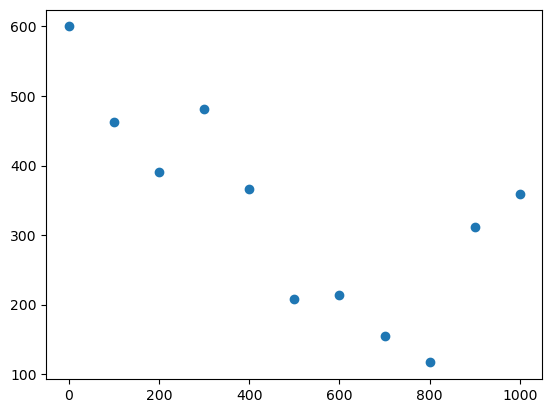

In [42]:
wf.register("pyiron_workflow.node_library.pyiron_atomistics", "pyiron_atomistics")
wf.register("pyiron_workflow.node_library.plotting", "plotting")

wf = Workflow("with_prebuilt")

wf.structure = wf.create.pyiron_atomistics.Bulk(cubic=True, name="Al")
wf.engine = wf.create.pyiron_atomistics.Lammps(structure=wf.structure)
wf.calc = wf.create.pyiron_atomistics.CalcMd(job=wf.engine)
wf.plot = wf.create.plotting.Scatter(
    x=wf.calc.outputs.steps, 
    y=wf.calc.outputs.temperature
)

out = wf.run()
out.plot__fig

In case you want to see more or less of the inner workings of the nodes when visualizing a workflow, you can modify the `depth` parameter, which controls how deeply child nodes are decomposed. E.g. we can force our workflow to only show us it's basic IO by setting `depth=0`:

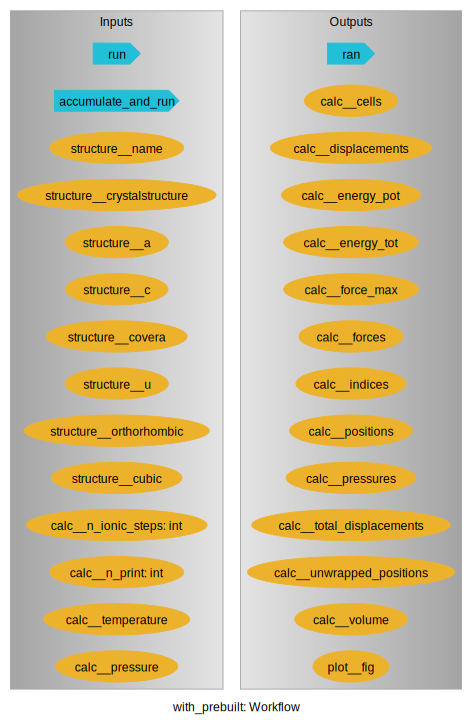

In [43]:
wf.draw(depth=0, size=(10, 10))

Note: the `draw` call returns a `graphviz.graphs.Digraphs` object; these get natively rendered alright in jupyter notebooks, as seen above, but you can also snag the object in a variable and do everything else graphviz allows, e.g. using the `render` method on the object to save it to file. Cf. the graphviz docs for details.

Workflows are "living" objects -- their IO is (re)created on access, so it is always up-to-date with the latest state of the workflow's children (who's there and who they're connected to), and (unless you explicitly tell it otherwise) a workflow will always re-compute the execution flow at run-time. This makes them incredibly convenient for working with as you put together a new computational graph, but is not particularly computationally efficient.

# Macros

Once you have a workflow that you're happy with, you may want to store it as a macro so it can be stored in a human-readable way, reused, shared, and executed with more efficiency than the "living" `Workflow` instance. Defining a new macro is pretty easy -- they are just composite nodes that have a function defining their input, graph setup, and output analogous to how `Function` nodes define their node function

In [44]:
from pyiron_workflow.macro import macro_node

In [45]:
@Workflow.wrap.as_function_node("result")
def AddOne(x):
    return x + 1

def add_three_macro(self, x):
    """
    The macro constructor `macro_node` expects the provided function 
    to take a `Macro` instance as its first argument, followed by any input data,
    and for output data to be returned `HasChannel` objects (i.e. a single-value 
    `Node` or an output data channel) 
    In the function body, it should add nodes to the macro, wire their connections, etc.
    """
    self.add_one = AddOne(x)
    self.add_two = AddOne(self.add_one)
    self.add_three = AddOne(self.add_two)
    # Just like workflows, for simple DAG macros we don't _need_
    # to set signals and starting nodes -- the macro will build them
    # automatically. But, if you do set both then the macro will use them
    self.add_one >> self.add_two >> self.add_three
    self.starting_nodes = [self.add_one]  
    # We _do_ need to specify the output of our macro,
    # which will typically be output channel(s) and/or single-return node(s)
    return self.add_three
    
macro = macro_node(add_three_macro)
macro(x=10).add_three

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io.py:404: UserWarning: The keyword 'type_hint' was not found among input labels. If you are trying to update a class instance keyword, please use attribute assignment directly instead of calling this method
  warnings.warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to x, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel run was not connected to ran, andthus could not disconnect from it.
  warn(


13

Note that the input and output channel labels are scraped from the decorated function. This is just like for `function_node`, but with one big exception: the `"self."` has been stripped off the returned value! Since the most likely thing to return is some child node, this is just a quality of life shortcut. Passing `output_labels=...` still works just like for `function_node`.

It will often be the case that this new macro will be made by copying and pasting some `wf = Workflow(...); ...` code that was explored. The use of `self` here reflects the canonical name for the own-instance argument, but for the sake of defining the function any variable will do! So you can use defintions like `def add_three_macro(wf, x):` just fine if that makes copy-pasting easier.

Of course, we can also use a decorator like for funciton nodes:

In [46]:
@Workflow.wrap.as_macro_node()
def AddThree(macro, x: int = 0):
    """
    The function decorator `as_macro_node` expects the decorated function 
    to take a `Macro` instance as its first argument, followed by any input data,
    and for output data to be returned `HasChannel` objects (i.e. a single-value 
    `Node` or an output data channel) 
    In the function body, it should add nodes to the macro, wire their connections, etc.
    """
    macro.add_one = AddOne(x)  # Directly use the input from the signature
    # Under the hood a new `UserInput` node is being created and used
    macro.add_two = AddOne(macro.add_one)
    macro.add_three = AddOne(macro.add_two)
    macro.outputs_map = {"add_two__result": "intermediate"}
    # We need to return something like output channels, but since AddOne has 
    # only a single output channel, we can return it directly.
    # We also return an intermediate value that would not normally be 
    # exposed if this were a workflow since it's connected to other child channels
    return macro.add_two, macro.add_three
    
macro = AddThree()
macro(x=100)
macro.outputs.to_value_dict()

{'add_two': 102, 'add_three': 103}

## Nesting

Composite nodes can be nested to abstract workflows into simpler components -- i.e. macros can be added to workflows, and macros can be used inside of macros. This is a critically important feature because it allows us to easily create more and more complex workflows by "composing" simple(r) sub-graphs together!

For our final example, let's define a macro for doing Lammps minimizations, then use this in a workflow to compare energies between different phases.

In [47]:
@Workflow.wrap.as_macro_node("structure", "energy")
def LammpsMinimize(self, element: str, crystalstructure: str, lattice_guess: float | int):
    self.structure = self.create.pyiron_atomistics.Bulk(
        name=element,
        crystalstructure=crystalstructure,
        a=lattice_guess
    )
    self.engine = self.create.pyiron_atomistics.Lammps(structure=self.structure)
    self.calc = self.create.pyiron_atomistics.CalcMin(job=self.engine, pressure=0)
    return self.structure, self.calc.outputs.energy_pot

In [48]:
LammpsMinimize.preview_outputs()

{'structure': None, 'energy': None}

Note that while `"self."` will get stripped off our return channel names, we're not allowed to have other `"."` characters in what remains -- so here where we're mixing and matching a returned (single-return-value) node and an explicit output channel (from a node with more than one output), we need to provide output labels. We could alternatively have given a nicely named local variable, e.g. `energy = self.calc.outputs.energy_pot; return return self.structure, energy` to get the same result.

In [49]:
wf = Workflow("phase_preference")
wf.element = wf.create.standard.UserInput()
wf.min_phase1 = LammpsMinimize(element=wf.element)
wf.min_phase2 = LammpsMinimize(element=wf.element)

wf.e1 = wf.min_phase1.outputs.energy[-1]
wf.n1 = wf.min_phase1.outputs.structure.len()
wf.e2 = wf.min_phase2.outputs.energy[-1]
wf.n2 = wf.min_phase2.outputs.structure.len()
wf.compare = (wf.e2 / wf.n2) - (wf.e1 / wf.n1)


# Or we could write a node to do that:

# @Workflow.wrap.as_function_node()
# def PerAtomEnergyDifference(structure1, energy1, structure2, energy2):
#     # The unrelaxed structure is fine, we're just using it to get n_atoms
#     sub = (energy2[-1]/len(structure2)) - (energy1[-1]/len(structure1))
#     return sub

# wf.compare = PerAtomEnergyDifference(
#     wf.min_phase1.outputs.structure,
#     wf.min_phase1.outputs.energy,
#     wf.min_phase2.outputs.structure,
#     wf.min_phase2.outputs.energy,
# )

wf.inputs_map = {
    "element__user_input": "element",
    "min_phase1__crystalstructure": "phase1",
    "min_phase2__crystalstructure": "phase2",
    "min_phase1__lattice_guess": "lattice_guess1",
    "min_phase2__lattice_guess": "lattice_guess2",
}

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to name, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to crystalstructure, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to a, andthus could not disconnect from it.
  warn(


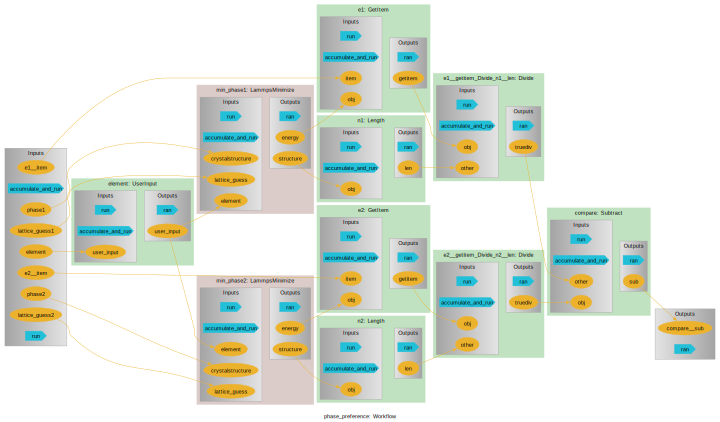

In [50]:
wf.draw(size=(10,10))

In [51]:
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=4, lattice_guess2=4)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__sub:.2f} eV/atom")

The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

Al: E(hcp) - E(fcc) = 1.17 eV/atom


In [52]:
out = wf(element="Mg", phase1="fcc", phase2="hcp", lattice_guess1=3, lattice_guess2=3)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__sub:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel ran was not connected to accumulate_and_run, andthus could not disconnect from it.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

Mg: E(hcp) - E(fcc) = -4.54 eV/atom


We can also replace entire node in a workflow or macro with a new node, booting the old one out and inserting the new one including all its connections. Because the connections are recreated, the replacement node _must_ have compatible IO to the node being replaced.

There are several syntacic approaches for doing this, including invoking replacement methods from the workflow (or macro) or from the node being replaced, or a new (compatible!) class can be assigned directly to an existing node. We'll use the last approach, which makes a new instance of the supplied class and replaces the target node with it.

Let's replace the calculation type for phase 1 -- let's switch it from a `CalcMin` to a `CalcStatic`; both of these take a `job` as input and give `structure` and `energy` as output, so we won't have any trouble connecting our new node in lieue of the old one.

In [53]:
replacee = wf.min_phase1.calc 
wf.min_phase1.calc = Workflow.create.pyiron_atomistics.CalcStatic

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel job was not connected to job, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel accumulate_and_run was not connected to ran, andthus could not disconnect from it.
  warn(


Since we're no longer allowing our first phase to relax while the second phase still can, we would expect the second phase to have a much lower energy than the first one. If our lattice guess for the first phase is bad enough, this could even switch the preferred phase!

Look at Al's fcc-hcp energy difference using this new workflow. We'll always let hcp relax, but freeze the fcc cell so we can see the impact of a good and bad lattice guess.

In [54]:
# Bad guess
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=3, lattice_guess2=3.1)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__sub:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel ran was not connected to accumulate_and_run, andthus could not disconnect from it.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

Al: E(hcp) - E(fcc) = -5.57 eV/atom


In [55]:
# Good guess
out = wf(element="Al", phase1="fcc", phase2="hcp", lattice_guess1=4.05, lattice_guess2=3.2)
print(f"{wf.inputs.element.value}: E({wf.inputs.phase2.value}) - E({wf.inputs.phase1.value}) = {out.compare__sub:.2f} eV/atom")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel ran was not connected to accumulate_and_run, andthus could not disconnect from it.
  warn(


The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

The job JUSTAJOBNAME was saved and received the ID: 9680


0it [00:00, ?it/s]

Al: E(hcp) - E(fcc) = 0.03 eV/atom


Now that we have nested macros, we can finally discuss the subtle difference between `__call__` and `pull`:

Each `Macro` instance is its own little walled garden, where it's child nodes have no connections apart from those to other children of the same macro (you can forceably change this, since we're all adults here, but it won't happen by default and isn't recommended). Under the hood this is accomplished by the macro IO "linking" itself to its childrens' IO, so that updates to macro input values are always immediately propagated to children, and macro output gets synchronized with its childrens' output at the end of every run. Because of this we can think of these children all having the same "scope", i.e. siblings among the same parent.

`pull` has a keyword argument to determine whether upstream data dependencies are restricted to be _in scope_, or if the parent node (if any) should also consider all _its_ data dependencies as well, and so on up until we hit the parent-most macro or workflow.

For `pull` this parameter defaults to `False`, so that the pull stops at the parent node. For `__call__` it defaults to `True`, so that the search for data dependencies punches right through parents and all the way up. The danger is that this might be expensive if there's an costly node somewhere in the dependency!

Note that the entire "pull" paradigm doesn't currently play nicely with remote execution. If some of your nodes have an executor specified, you will need to `.run` your graph (or `__call__` a `Workflow` if that's your parent-most object) so that it runs in "push" mode, and the nodes running on an executor are guaranteed to have up-to-date input _before_ they get shipped off to another process.

## Parallelization

You can currently run nodes in different process by setting that node's `executor` to an instance of a compliant executor object -- i.e. that takes the standard `submit` method of `concurrent.futures.Executor`, returns a `concurrent.futures.Future` (or sub-class), and can handle serializing dynamically defined objects. We make a handful of such compliant executors available on the creator. There is a toy `CloudpickleProcessPoolExecutor` which is a minimal example of compliance and useful for learning, but we also link to the executors provided by `pympipool`. Depending on your installation of `pympipool`, it's possible that only the `PyMPIExecutor` will be available, and this is what is provided by default under the creator's `Executor` attribute. 

Here's a simple example of executor usage:

In [56]:
wf = Workflow("with_executor")
wf.a1 = wf.create.standard.Add(0, 1)
wf.a2 = wf.create.standard.Add(2, 3)
wf.b = wf.a1 + wf.a2

wf.a2.executor = wf.create.Executor()
wf()

print(wf.a1.future, wf.a1.outputs.add.value)
print(wf.a2.future, wf.a2.outputs.add.value)

None 1
<Future at 0x13ecb5590 state=pending> NOT_DATA


We can see that the regularly-executing node gets its output as usual, but the node with an executor gets its `future` attribute populated and isn't finished yet

In [57]:
print("Finally", wf.a2.future.result())
print(wf.b)

Finally 5
b (Add):
Inputs ['obj', 'other']
Outputs ['add']
InputSignals ['run', 'accumulate_and_run']
OutputSignals ['ran']


When you're all done, it's best practice to shut down your `pympipool` executor to make sure you don't leave any dangling process (similar to how opened files should be closed). This can be done with a convience method from the parent-most object, which will recursively shut down all executors:

In [58]:
wf.executor_shutdown()

Alternatively, we can use the `with` context for executors, as along as it encompasses our entire workflow. This might be useful if you are working with a single executor. In this case the `with` context handles shutdown cleanly without our help:

In [59]:
with Workflow.create.Executor() as executor:
    wf = Workflow("with_executor")
    wf.a1 = wf.create.standard.Add(0, 1)
    wf.a2 = wf.create.standard.Add(2, 3)
    wf.b = wf.a1 + wf.a2

    wf.a2.executor = executor
    wf()
    
    print(wf.a1.future, wf.a1.outputs.add.value)
    print(wf.a2.future, wf.a2.outputs.add.value)
    
    print("Finally", wf.a2.future.result())
    print(wf.b)

None 1
<Future at 0x13ed84850 state=running> NOT_DATA
Finally 5
b (Add):
Inputs ['obj', 'other']
Outputs ['add']
InputSignals ['run', 'accumulate_and_run']
OutputSignals ['ran']


For DAGs, workflows and macros automated execution flow makes use of the `.signals.inputs.accumulate_and_run` signal to run as soon as _all_ the up-data-stream nodes have finished.

Before we wrap up our conversation of executors, let's make both linear and accumulating workflows by-hand, and see the time difference parallelization can bring. We'll use the `>>` and `<<` syntactic sugar for defining direct and accumulating run signals, respectively:

In [60]:
from time import perf_counter, sleep

from pyiron_workflow.channels import NOT_DATA

@Workflow.wrap.as_function_node()
def Wait(t):
    sleep(t)
    return True
    
t = 2

In [61]:
wf = Workflow("serial")
wf.a = Wait(t)
wf.b = Wait(t)
wf.c = Wait(t)
wf.d = wf.create.standard.UserInput(t)
wf.automate_execution = False
wf.a >> wf.b >> wf.c >> wf.d
wf.starting_nodes = [wf.a]
t0 = perf_counter()
out = wf()
while wf.outputs.d__user_input.value is NOT_DATA:
    sleep(0.001)
dt_serial = perf_counter() - t0

print(dt_serial)

6.01380590700137


In [62]:
wf = Workflow("parallel")
wf.a = Wait(t)
wf.b = Wait(t)
wf.c = Wait(t)
wf.d = wf.create.standard.UserInput(t)
wf.automate_execution = False
wf.d << (wf.a, wf.b, wf.c)
wf.starting_nodes = [wf.a, wf.b, wf.c]


with wf.create.Executor(max_workers=3, cores_per_worker=1) as executor:
    wf.a.executor = executor
    wf.b.executor = executor
    wf.c.executor = executor

    t1 = perf_counter()
    out = wf()
    while wf.outputs.d__user_input.value is NOT_DATA:
        sleep(0.001)
    dt_parallel = perf_counter() - t1

print(dt_parallel)

2.925749412010191


Note how we've used the `<<` syntax to load up the `accumulate_and_run` input signal with multiple connections at once (as opposed to the forwards-syntactic sugar that connects one item at a time to `run`), and leveraging a single executor in a `with` statement. But most of all, note the speedup! There is some overhead for shipping things off to an executor -- we don't want to do it for operations that are taking mere ms -- but the bar is not super high. Serializing different nodes may take different amounts of time depending on how complex they are, so check for yourself the tradeoff between executing your nodes in parallel or serial.

#### Executor limitations

Unfortunately, _nested_ executors are not yet working. So if you set a macro to use an executor, none of its (grand...)children may specify an executor.

# Here be dragons

While everything in the workflows sub-module is under development, the following complex features are _even more likely_ to see substantial modifications to their interface and behaviour. Nonetheless, they're fun so let's look at them.

## Saving and loading

For python >= 3.11, graphs can be saved and loaded on request -- either by manually invoking the `.save()` method, or by setting the `save_after_run` attribute to `True` (on the object or at instantiation by kwarg). This creates a save file (currently using HDF5 as a format) in the parent-most node's working directory.

Subsequently instantiating a node with the same name in the same place will attempt to reload the saved graph automatically. 

Since data IO is also saved, all IO must be serializable. As a fallback, we attempt to store data IO values using pickle, so most pickle-able objects will work.

You can look at the `Node` class docstring for a full and detailed list of all storage features as they currently are in this alpha feature, but here are a few key caveats:
- The _entire graph_ is always saved, regardless of which node is calling `save()`
- Similarly, you can only reload the entire graph at once
- Also related, there is currently zero filtering of which data, or to which depth the graph gets stored -- it's all or nothing
- If the source code for nodes gets modified between saving and loading, weird stuff is likely to happen, and some of it may happen silently.

Lastly, we currently use two backends: `tinybase.storage.H5ioStorage` and `h5io` directly. They have slightly different strengths:
- `"h5io"` (the default) 
  - Will let you save and load any nodes that defined by subclassing (this includes all nodes defined using the decorators)
  - Will preserve changes to a macro (replace/add/remove/rewire)
  - Has trouble with some data
- `"tinybase"`
  - Requires all nodes to have been instantiated with the creator (`wf.create...`; this means moving node definitions to a `.py` file in your pythonpath and registering it as a node package -- not particularly difficult!)
  - _Ignores_ changes to a macro (will crash nicely if the macro IO changed)
  - Falls back to `pickle` for data failures, so can handle a wider variety of data IO objects

In [63]:
import sys

In [64]:
if sys.version_info >= (3, 11):
    wf = Workflow("save_demo")
    wf.inp = wf.create.standard.UserInput(42)
    wf.middle = 2 * wf.inp
    wf.end = wf.middle - 42
    wf.out = wf.create.standard.UserInput(wf.end, save_after_run=True)
    wf()
    # wf.save()  # Not needed, since `wf.out` saves after running

In [65]:
if sys.version_info >= (3, 11):
    reloaded = Workflow("save_demo")
    reloaded.out.value == wf.out.value

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/node.py:337: UserWarning: A saved file was found for the node save_demo -- attempting to load it...(To delete the saved file instead, use `overwrite_save=True`)
  warnings.warn(


You can force a newly instantiated node to ignore (and delete!) an existing save file by setting the `overwrite_save` kwarg to `True`.

Finally, let's clean up our save to keep this demo director clean:

In [66]:
if sys.version_info >= (3, 11):
    reloaded.storage.delete()

## Meta-nodes and flow control

A meta-node is a function that produces a node _class_ instedad of a node _instance_.
Right now, these are used to produce parameterized flow-control nodes, which take an node class as input and return a new macro class that builds some graph using the passed node class, e.g. for- and while-loops.

Note: The body (and condition) node classes passed to for- and while-loops must be importable, i.e. they can come from a node package, or be defined here in the notebook (importable from `__main__`), but you can't use, e.g., a node defined _inside_ the scope of some other function.

### For-loops

One meta node is a for-loop builder, which creates a macro with $n$ internal instances of the "loop body" node class, and a new IO interface.
The new input allows you to specify which input channels are being looped over -- such that the macro input for this channel is interpreted as list-like and distributed to all the copies of the nodes separately --, and which is _not_ being looped over -- and thus interpreted as the loop body node would normally interpret the input and passed to all copies equally.
All of the loop body outputs are then collected as a list of length $n$.

We follow a convention that inputs and outputs being looped over are indicated by their channel labels being ALL CAPS.

In the example below, we loop over the bulk structure node to create structures with different lattice constants:

In [67]:
n = 5

bulk_loop = Workflow.create.meta.for_loop(
    Workflow.create.pyiron_atomistics.Bulk,
    n,
    iterate_on=("a",),
)()

out = bulk_loop(
    name="Al",  # Sent equally to each body node
    A=np.linspace(3.9, 4.1, n).tolist(),  # Scattered across body nodes
    # The rest of the values need to be filled
    # (We don't currently pass body defaults to the loop node)
    # but just get broadcast to each body node
    crystalstructure=None,
    a=None,
    c=None,
    covera=None,
    u=None,
    orthorhombic=False,
    cubic=False
)

[struct.cell.volume for struct in out.STRUCTURE]  
# output is a list collected from copies of the body node, as indicated by CAPS label

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io_preview.py:245: OutputLabelsNotValidated: Could not find the source code to validate BulkForA5 output labels against the number of returned values -- proceeding without validation
  warnings.warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io.py:404: UserWarning: The keyword 'type_hint' was not found among input labels. If you are trying to update a class instance keyword, please use attribute assignment directly instead of calling this method
  warnings.warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io_preview.py:245: OutputLabelsNotValidated: Could not find the source code to validate __many_to_list output labels against the number of returned values -- proceeding without validation
  warnings.warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io.py:404: UserWarning: The keyword 'a' was not found among input labels. If you are trying to update a class instance keyword, please use att

[14.829749999999995,
 15.407468749999998,
 15.999999999999998,
 16.60753125,
 17.230249999999995]

## While-loops

We can also create a while-loop, which takes both a body node and a condition node. The condition node must be a single-output `Function` node returning a `bool` type. Instead of creating copies of the body node, the body node gets re-run until the condition node returns `False`.

You _must_ specify the data connection so that the body node passes information to the condition node. You may optionally also loop output of the body node back to input of the body node to change the input at each iteration. Right now this is done with horribly ugly string tuples, but we're still working on it.

In [68]:
@Workflow.wrap.as_function_node("sum")
def Add(a, b):
    print(f"{a} + {b} = {a + b}")
    return a + b

AddWhile = Workflow.create.meta.while_loop(
    loop_body_class=Add,
    condition_class=Workflow.create.standard.LessThan,
    internal_connection_map=[
        ("Add", "sum", "LessThan", "obj"),
        ("Add", "sum", "Add", "a")
    ],
    inputs_map={"Add__a": "a", "Add__b": "b", "LessThan__other": "threshold"},
    outputs_map={"Add__sum": "total"}
)

wf = Workflow("do_while")
wf.add_while = AddWhile(threshold=10)

wf.inputs_map = {
    "add_while__a": "a",
    "add_while__b": "b"
}
wf.outputs_map = {
    "add_while__total": "total",  # Rename this output
    "add_while__switch__truth": None  # Disable this output
}

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io_preview.py:245: OutputLabelsNotValidated: Could not find the source code to validate AddWhileLessThan_m717539476586907336 output labels against the number of returned values -- proceeding without validation
  warnings.warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to a, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to b, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to other, andthus could not disconnect from it.
  warn(
/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel run was not connected to true, andthus could not disconnect from it.
  wa

Note that initializing the `a` and `b` input to numeric values when we call the workflow below does not destroy the connection made between the body node input and output -- so the first run of the body node uses the initial value passed, but then it updates its own input for subsequent calls!

In [69]:
response = wf(a=1, b=2)
print("Finally", response)

1 + 2 = 3
3 + 2 = 5
5 + 2 = 7
7 + 2 = 9
9 + 2 = 11
Finally {'total': 11}


In [70]:
@Workflow.wrap.as_function_node("random")
def Random(length: int | None = None):
    return np.random.random(length)

@Workflow.wrap.as_function_node()
def GreaterThan(x: float, threshold: float):
    gt = x > threshold
    symbol = ">" if gt else "<="
    print(f"{x:.3f} {symbol} {threshold}")
    return gt

RandomWhile = Workflow.create.meta.while_loop(
    loop_body_class=Random,
    condition_class=GreaterThan,
    internal_connection_map=[("Random", "random", "GreaterThan", "x")],
    inputs_map={"GreaterThan__threshold": "threshold"},
    outputs_map={"Random__random": "capped_result"}
)

# Define workflow

wf = Workflow("random_until_small_enough")

## Wire together the while loop and its condition

wf.random_while = RandomWhile()

## Give convenient labels
wf.inputs_map = {"random_while__threshold": "threshold"}
wf.outputs_map = {"random_while__capped_result": "capped_result"}

print(f"Finally {wf(threshold=0.2).capped_result:.3f}")

/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/io_preview.py:245: OutputLabelsNotValidated: Could not find the source code to validate RandomWhileGreaterThan_m9123908231955290806 output labels against the number of returned values -- proceeding without validation
  warnings.warn(


0.400 > 0.2
0.081 <= 0.2
Finally 0.081


/Users/huber/work/pyiron/pyiron_workflow/pyiron_workflow/channels.py:176: UserWarning: The channel user_input was not connected to threshold, andthus could not disconnect from it.
  warn(
